# Goal: predict whether a player is to be considered a candidate for the NBA Most Valuable Player (MVP) award during the 2022-23 regular season.
- For the purpose of this project, we will utilize individual player stats for the 2022-23 NBA regular season (source: Kaggle / https://www.basketball-reference.com/leagues/NBA_2023_per_game.html)
- An 'MVP candidate' will be defined as an NBA player who exhibits exceptional individual performance over the course of the season
- The data will be trained on three different learning models (decision tree, SVM, and kNN), with the possibility for more, if time permits.
- Stats related to team performance, such as Win Percentage, Win Share and PER, will not be considered as the proper variables are not included in the data set and cannot be properly calculated with the available data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn import mixture, svm, linear_model, tree

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm, linear_model, datasets
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

warnings.filterwarnings('ignore')

## Read 2022-23 NBA Individual Regular Season stats into a DataFrame

In [2]:
nba_df = pd.read_csv("nba_data_processed_v2.csv")
nba_df.head(5)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,0.597,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.540,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,0.470,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0


## Remove duplicate player rows
- Observing the data set, we see duplicated values for players that changed teams during the season.
- Since we are not concerned with the player's team for the sake of this project, we will only retain the rows denoted by 'TOT' in the Teams column for these players.

In [3]:
nba_df = nba_df.drop_duplicates(subset='Player', keep='first')
nba_df.head(10)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,0.485,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,0.597,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,0.540,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,0.427,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,0.470,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0
5,Nickeil Alexander-Walker,SG,24,TOT,59,3,15.0,2.2,5.0,0.444,...,0.667,0.3,1.5,1.7,1.8,0.5,0.4,0.9,1.5,6.2
8,Grayson Allen,SG,27,MIL,72,70,27.4,3.4,7.7,0.440,...,0.905,0.8,2.4,3.3,2.3,0.9,0.2,1.0,1.6,10.4
9,Jarrett Allen,C,24,CLE,68,68,32.6,5.9,9.2,0.644,...,0.733,3.3,6.5,9.8,1.7,0.8,1.2,1.4,2.3,14.3
10,Jose Alvarado,PG,24,NOP,61,10,21.5,3.3,8.0,0.411,...,0.813,0.5,1.9,2.3,3.0,1.1,0.2,1.3,2.0,9.0
11,Kyle Anderson,PF,29,MIN,69,46,28.4,3.7,7.2,0.509,...,0.735,1.0,4.4,5.3,4.9,1.1,0.9,1.5,2.1,9.4


## Create a calculated value for player efficiency (EFF) and append to existing DataFrame
- The player efficiency formula is defined as follows: $\\$
$EFF = \frac{PTS \ + \ STL \ + \ BLK \ + \ TRB \ + \ AST \ - \ FT \ Missed \ - \ FG \ Missed \ - \ TOV}{Minutes \ Played}$

In [4]:
EFF = (nba_df['PTS'] + nba_df['STL'] + nba_df['BLK'] + nba_df['TRB'] + nba_df['AST'] - (nba_df['FTA'] - nba_df['FT']) - (nba_df['FGA'] - nba_df['FG']) - nba_df['TOV']) / nba_df['MP']
nba_df['EFF'] = EFF
nba_df = nba_df.dropna()
nba_df = nba_df.sort_values("EFF", ascending=False)
nba_df.head(12)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,EFF
318,Nikola Jokić,C,27,DEN,69,69,33.7,9.4,14.8,0.632,...,2.4,9.4,11.8,9.8,1.3,0.7,3.6,2.5,24.5,1.127596
184,Joel Embiid,C,28,PHI,66,66,34.6,11.0,20.1,0.548,...,1.7,8.4,10.2,4.2,1.0,1.7,3.4,3.1,33.1,1.040462
12,Giannis Antetokounmpo,PF,28,MIL,63,63,32.1,11.2,20.3,0.553,...,2.2,9.6,11.8,5.7,0.8,0.8,3.9,3.1,31.1,1.021807
141,Anthony Davis,C,29,LAL,56,54,34.0,9.7,17.2,0.563,...,3.5,9.1,12.5,2.6,1.1,2.0,2.2,2.6,25.9,0.961765
160,Luka Dončić,PG,23,DAL,66,66,36.2,10.9,22.0,0.496,...,0.8,7.8,8.6,8.0,1.4,0.5,3.6,2.5,32.4,0.925414
549,Domantas Sabonis,C,26,SAC,79,79,34.6,7.3,11.9,0.615,...,3.2,9.1,12.3,7.3,0.8,0.5,2.9,3.5,19.1,0.898844
174,Kevin Durant,PF-SF,34,TOT,47,47,35.6,10.3,18.3,0.560,...,0.4,6.3,6.7,5.0,0.7,1.4,3.3,2.1,29.1,0.870787
209,Shai Gilgeous-Alexander,PG,24,OKC,68,68,35.5,10.4,20.3,0.510,...,0.9,4.0,4.8,5.5,1.6,1.0,2.8,2.8,31.4,0.859155
139,Stephen Curry,PG,34,GSW,56,56,34.7,10.0,20.2,0.493,...,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4,0.844380
306,LeBron James,PF,38,LAL,55,54,35.5,11.1,22.2,0.500,...,1.2,7.1,8.3,6.8,0.9,0.6,3.2,1.6,28.9,0.842254


## Based on the first 12 players, the calculated value appears to work well 
- The highest observed efficiency rating among these players is Bucks Power Forward Giannis Antetokounmpo, a two-time NBA Most Valuable Player and present MVP candidate.
- However, even though Andre Drummond has a relative high EFF score, he is not a present day star player. One reason for this is that he can be efficient in short time but his efficiency is not consistent throughout the time. Thus, we have to add a new filter in which player has to play more than 30 minutes per game and at least 50 games played within the season.

## Create a binary variable called MVP that we will attempt to predict with the data.
- The value is decided by historic constraints for previous MVPs including an efficiency rating greater than 0.8, greater than 30 minutes played per game, and more than 50 games played within the season.

In [5]:
#labels historic MVP characteristics (sourced through https://www.statmuse.com/)
MVP = (nba_df['EFF'] > 0.8) & (nba_df['MP'] > 30) & (nba_df['G'] > 50)
nba_df['MVP'] = MVP

# Model 1: Decision Tree Classification
- We will utilize the features PTS and EFF to classify each player as an MVP candidate or not.
- The feature TRB was originally included in place of EFF but later removed as it created bias towards power forwards and centers.

Accuracy on training data is 1.0.


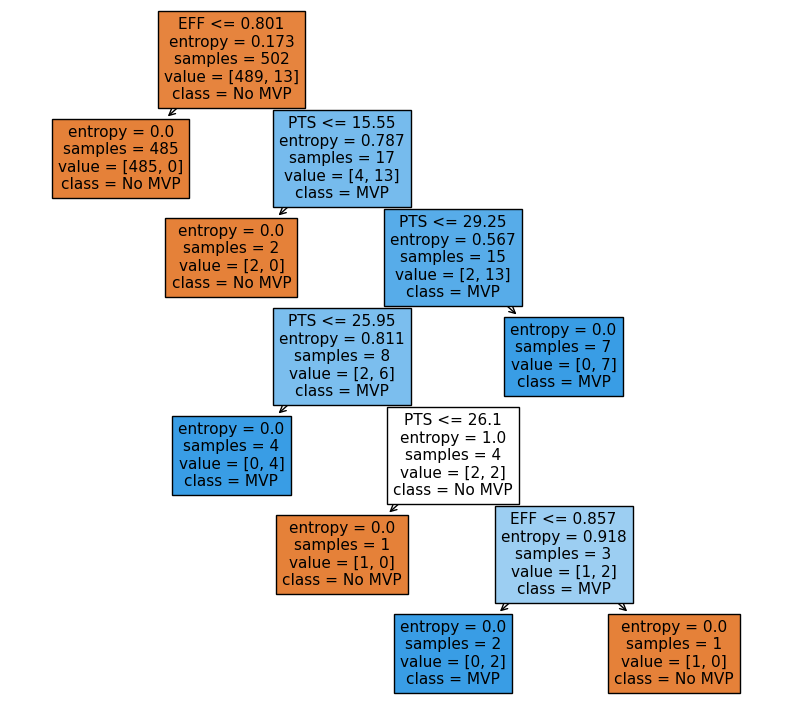

In [6]:
feature_names = ['PTS', 'EFF']
X = nba_df[feature_names]
y = nba_df.MVP
clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
clf.fit(X, y)
class_names = ['No MVP', 'MVP']

plt.rcParams["figure.figsize"] = (10, 9)
tree.plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True)
clf.score(X, y)
print(f'Accuracy on training data is {clf.score(X, y)}.')

## The decision tree classifier appears to be a decent choice for MVP candidacy classification
- One interesting thing to note is the classification of four samples as MVP candidates which average no more than 25.95 points per game but possess an efficiency rating of at least 0.801.
- This is likely an indication that the utilization of efficiency rating allows the decision tree to assess other variables, such as rebounds and assists, by comparing efficiency rating against points per game.
- However, the decision tree appears to be overfit to the data set.

# Model 2: Support Vector Machine (SVM)

In [7]:
clf = svm.SVC(kernel='linear', C=1000, random_state=0)
clf.fit(X, y)
clf.score(X, y)
print(f'clf.coef_={clf.coef_}')
print(f'clf.intercept_={clf.intercept_}')
print(f'The decision boundary is 0.1255 * PTS + 20.422 * EFF - 19.74 = 0.')
print(f'The training accuracy is {clf.score(X, y):.3}.')

clf.coef_=[[ 0.12551435 20.42230277]]
clf.intercept_=[-19.74050055]
The decision boundary is 0.1255 * PTS + 20.422 * EFF - 19.74 = 0.
The training accuracy is 0.992.


## Based on the previous coefficients, PTS and TRB are the most significant of the three variables. We will plot the data in relation to these variables.

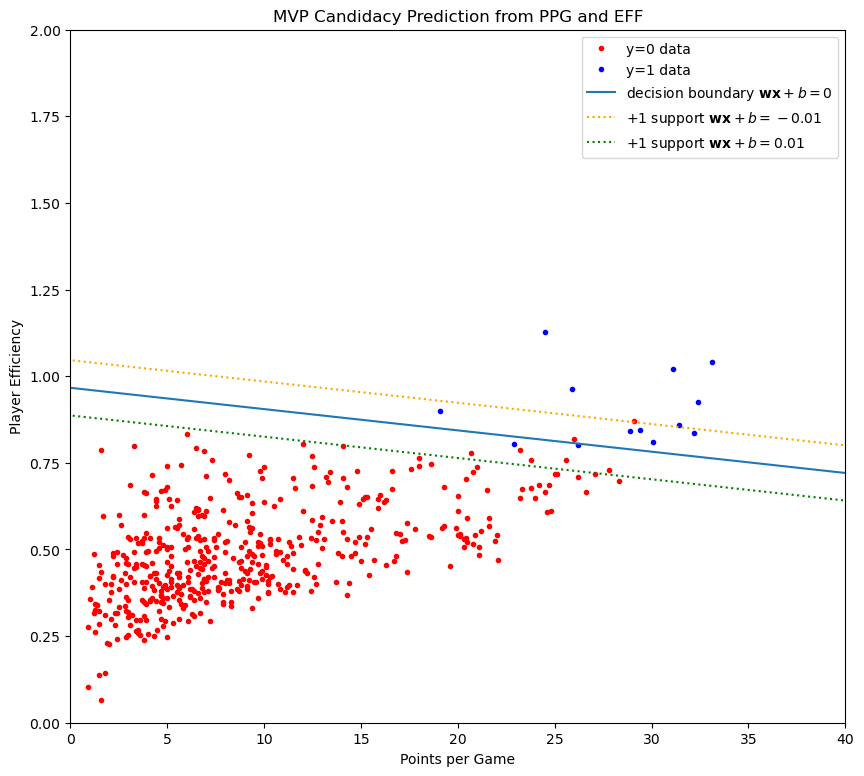

In [8]:
# Not MVP candidate
plt.plot(nba_df.PTS[y == 0], nba_df.EFF[y == 0], '.', color='red', label='y=0 data')
# MVP candidate
plt.plot(nba_df.PTS[y ==  1], nba_df.EFF[y ==  1], '.', color='blue', label='y=1 data')
# decision boundary
x2 = nba_df.PTS
x1 = -(clf.coef_[0][1] * x2 + clf.intercept_) / clf.coef_[0][0]
x2_extended = np.linspace(start=min(nba_df.PTS)-2, stop=max(nba_df.PTS)+2, num=100) # extend line beyond min/max PTS
x1_extended = -(clf.coef_[0][1] * x2_extended + clf.intercept_) / clf.coef_[0][0] # calculate corresponding EFF values
plt.plot(x1_extended, x2_extended, label=r'decision boundary $\mathbf{wx} + b = 0$')
#plt.plot(x1, x2, label=r'decision boundary $\mathbf{wx} + b = 0$')
# upper and lower margin boundaries
plt.plot(x1_extended, x2_extended + 0.01 / clf.coef_[0][0], linestyle=':', color='orange', label=r'+1 support $\mathbf{wx} + b =  -0.01$')
plt.plot(x1_extended, x2_extended - 0.01 / clf.coef_[0][0], linestyle=':', color='green', label=r'+1 support $\mathbf{wx} + b = 0.01$')
# title, axis labels, legend, axis limits
plt.xlim(0, 40)
plt.ylim(0, 2)
plt.xlabel('Points per Game')
plt.ylabel('Player Efficiency')
plt.title('MVP Candidacy Prediction from PPG and EFF')
plt.legend()

## The decision boundary does not appear to be strict, as many data points labeled with y=0 are located to the right of the decision boundary
- Likely reason for this would be that these players did not exceed historic thresholds needed for MVP candidacy that are not considered in the decision boundary.
- For example, Pelicans Power Forward Zion Williamson falls to the right of the decision boundary, but since he only played in 29 games during the season, he would be falsely classified as an MVP candidate.

In [9]:
nba_df[nba_df['Player'] == "Zion Williamson"]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,EFF,MVP
664,Zion Williamson,PF,22,NOP,29,29,33.0,9.8,16.2,0.608,...,5.0,7.0,4.6,1.1,0.6,3.4,2.2,26.0,0.818182,False


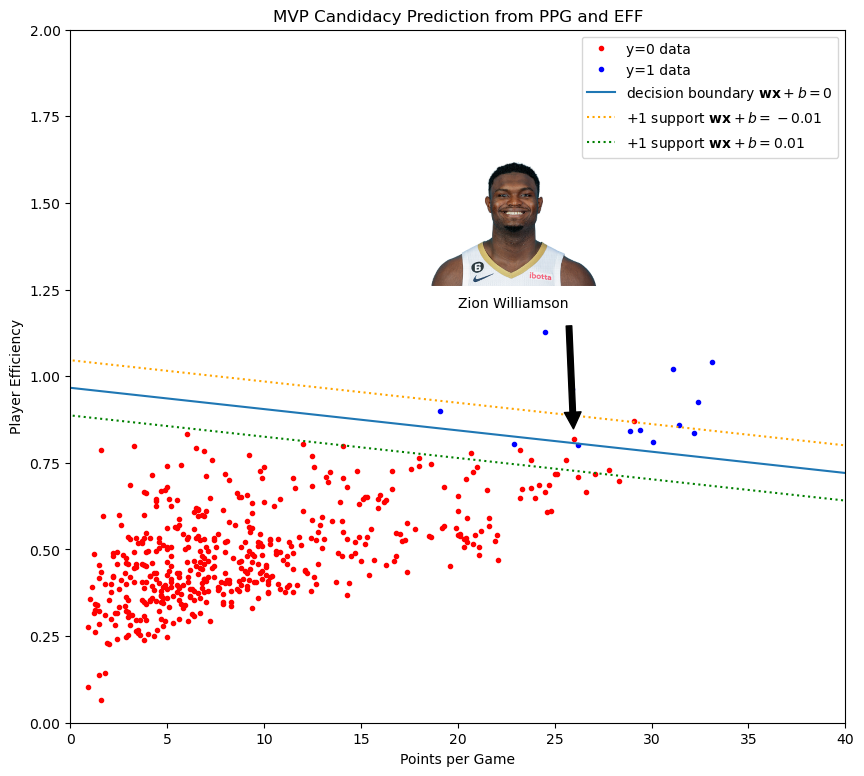

In [10]:
# Not MVP candidate
plt.plot(nba_df.PTS[y == 0], nba_df.EFF[y == 0], '.', color='red', label='y=0 data')
# MVP candidate
plt.plot(nba_df.PTS[y ==  1], nba_df.EFF[y ==  1], '.', color='blue', label='y=1 data')
# decision boundary
x2 = nba_df.PTS
x1 = -(clf.coef_[0][1] * x2 + clf.intercept_) / clf.coef_[0][0]
x2_extended = np.linspace(start=min(nba_df.PTS)-2, stop=max(nba_df.PTS)+2, num=100) # extend line beyond min/max PTS
x1_extended = -(clf.coef_[0][1] * x2_extended + clf.intercept_) / clf.coef_[0][0] # calculate corresponding EFF values
plt.plot(x1_extended, x2_extended, label=r'decision boundary $\mathbf{wx} + b = 0$')
#plt.plot(x1, x2, label=r'decision boundary $\mathbf{wx} + b = 0$')
# upper and lower margin boundaries
plt.plot(x1_extended, x2_extended + 0.01 / clf.coef_[0][0], linestyle=':', color='orange', label=r'+1 support $\mathbf{wx} + b =  -0.01$')
plt.plot(x1_extended, x2_extended - 0.01 / clf.coef_[0][0], linestyle=':', color='green', label=r'+1 support $\mathbf{wx} + b = 0.01$')
# title, axis labels, legend, axis limits
plt.xlim(0, 40)
plt.ylim(0, 2)
plt.xlabel('Points per Game')
plt.ylabel('Player Efficiency')
plt.title('MVP Candidacy Prediction from PPG and EFF')
plt.legend()
# read image file
im = plt.imread('zion.png')
# add arrow pointing to x=26, y=0.81 labeled with image
plt.annotate('Zion Williamson', xy=(26, 0.81), xytext=(20, 1.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.figimage(im, xo=415, yo=490)


# Model 3: k-Nearest Neighbors Classifier (kNN)

In [11]:
# Define features and target variable
feature_names = ['PTS', 'TRB', 'AST', 'STL', 'BLK']
target = ['MVP']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(nba_df[feature_names], nba_df[target], test_size=0.2, random_state=0)

# Train the SVM model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train.values.ravel())

# Test the model on the testing set
accuracy = knn.score(X_test, y_test)
print(f'The training accuracy is {accuracy}.')

The training accuracy is 1.0.


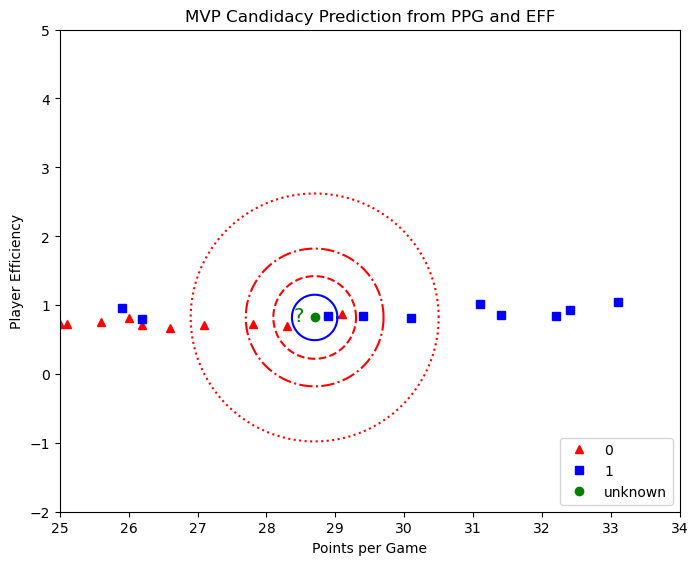

In [12]:
# draw points
plt.figure(figsize=(8,8))
plt.plot(nba_df.PTS[y == 0], nba_df.EFF[y == 0], '^r', label='0') # red triangles
plt.plot(nba_df.PTS[y == 1], nba_df.EFF[y == 1], 'sb', label='1') # blue squares
plt.plot(28.7, 0.82, 'og', label='unknown') # green dot for NBA player averaging 28.7 PTS on 0.82 EFF
plt.text(x=28.4, y=0.77, s='?', color='green', fontsize='x-large') # green question mark
             
# draw circles to contain 1, 3, 5, and 7 points
theta = np.linspace(start=0, stop=2*np.pi, num=100)
radius = [0.33, 0.6, 1, 1.8]
linestyle = ['solid', 'dashed', 'dashdot', 'dotted']
circle_color = ['blue', 'red', 'red', 'red']
center = (28.7, 0.82)

for i in range(len(radius)):
    plt.plot(radius[i] * np.cos(theta) + center[0], radius[i] * np.sin(theta) + center[1],
             linestyle=linestyle[i], color=circle_color[i])
plt.axis('square')
plt.xlim(25, 34)
plt.ylim(-2, 5)
plt.xlabel('Points per Game')
plt.ylabel('Player Efficiency')
plt.title('MVP Candidacy Prediction from PPG and EFF')
plt.legend(loc='lower right')
plt.savefig(fname='kNN.png')
plt.show(block=False)

In [13]:
k_values = [1, 3, 5, 7]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    knn.fit(X, y)
    X_green = pd.DataFrame({'PTS': [28.7], 'EFF': [0.82]})
    print(f'For k={k}, predict green is {knn.predict(X_green)[0].astype(int)}.')
    
k_values = [1, 3, 5, 7]
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k, metric='euclidean')
    knn.fit(X, y)
    print(f'For k={k}, predict green is {knn.predict(X_green)[0]:.3}.') 

For k=1, predict green is 1.
For k=3, predict green is 0.
For k=5, predict green is 0.
For k=7, predict green is 0.
For k=1, predict green is 1.0.
For k=3, predict green is 0.333.
For k=5, predict green is 0.4.
For k=7, predict green is 0.429.


## For k = 1, k-nearest neighbors indicates a player averaging 28.7 points on 0.82 efficiency would be a MVP candidate. For k $\geq$ 3, however, it would appear that the classifier would determine the player to not be a MVP candidate.
- The disproportion between MVP-caliber players and the rest of the league creates an advantage in favor of classifying players as not MVP candidates.

# Conclusions:

- Overall, we would conclude that the $\textbf{support vector machine}$ is the most appropriate for predicting whether a player is a MVP candidate, featuring an accuracy score of 0.992. The application of this method can predict whether a player is to be considered 'MVP-caliber' with relatively strong accuracy based on individual accolades, with only four mislabeled players among hundreds.

- The decision tree classifier appears to be a relatively strong method of determination on the surface. However, the decision tree is overfit to the data, making it difficult to trust the results that it will produce.

- The k-nearest neighbors method is the weakest of the three classifiers for this data set, as the data heavily favors classifying players to not be MVP candidates. 

- While the accuracy score for the decision tree classifier is 1.0, the classification of players as MVP candidates is subjective. The winner of the award is determined by voting among sports media personnel, who may or may not consider aspects such as "narrative", a variable which is very difficult to measure quantitatively.

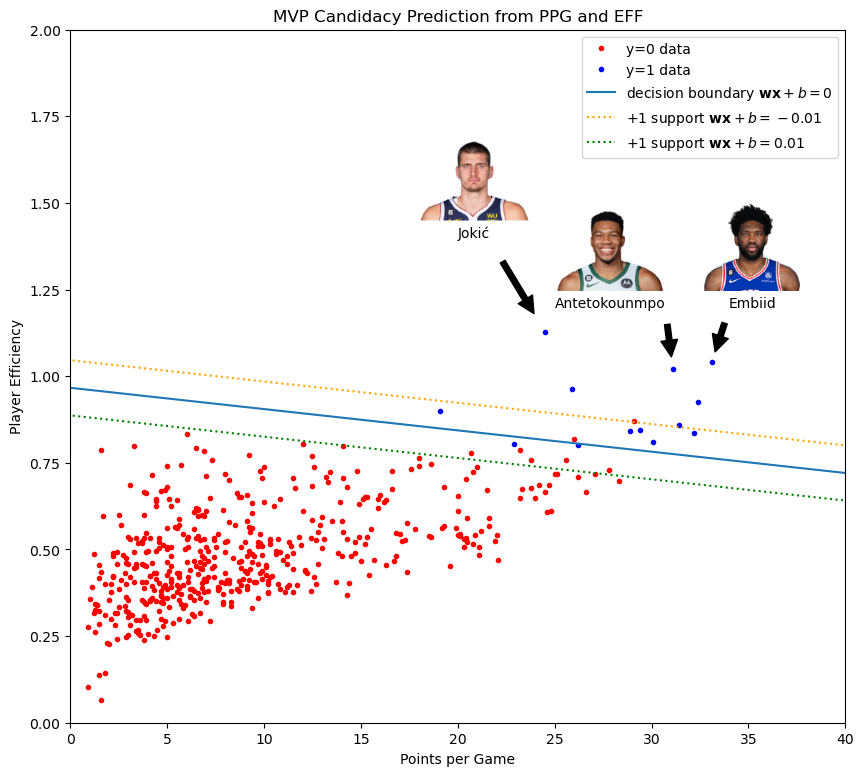

In [14]:
# Not MVP candidate
plt.plot(nba_df.PTS[y == 0], nba_df.EFF[y == 0], '.', color='red', label='y=0 data')
# MVP candidate
plt.plot(nba_df.PTS[y ==  1], nba_df.EFF[y ==  1], '.', color='blue', label='y=1 data')
# decision boundary
x2 = nba_df.PTS
x1 = -(clf.coef_[0][1] * x2 + clf.intercept_) / clf.coef_[0][0]
x2_extended = np.linspace(start=min(nba_df.PTS)-2, stop=max(nba_df.PTS)+2, num=100) # extend line beyond min/max PTS
x1_extended = -(clf.coef_[0][1] * x2_extended + clf.intercept_) / clf.coef_[0][0] # calculate corresponding EFF values
plt.plot(x1_extended, x2_extended, label=r'decision boundary $\mathbf{wx} + b = 0$')
#plt.plot(x1, x2, label=r'decision boundary $\mathbf{wx} + b = 0$')
# upper and lower margin boundaries
plt.plot(x1_extended, x2_extended + 0.01 / clf.coef_[0][0], linestyle=':', color='orange', label=r'+1 support $\mathbf{wx} + b =  -0.01$')
plt.plot(x1_extended, x2_extended - 0.01 / clf.coef_[0][0], linestyle=':', color='green', label=r'+1 support $\mathbf{wx} + b = 0.01$')
# title, axis labels, legend, axis limits
plt.xlim(0, 40)
plt.ylim(0, 2)
plt.xlabel('Points per Game')
plt.ylabel('Player Efficiency')
plt.title('MVP Candidacy Prediction from PPG and EFF')
plt.legend()

# read giannis image file
image_ga = plt.imread('giannis.png')
# add arrow pointing to x=31.1, y=1.022 labeled with image
plt.annotate('Antetokounmpo', xy=(31.1, 1.022), xytext=(25, 1.2),
             arrowprops=dict(facecolor='black', shrink=0.2))
plt.figimage(image_ga, xo=545, yo=485)

# read jokic image file
image_nk = plt.imread('jokic.png')
# add arrow pointing to x=24.5, y=1.128 labeled with image
plt.annotate('Jokić', xy=(24.5, 1.128), xytext=(20, 1.4),
             arrowprops=dict(facecolor='black', shrink=0.2))
plt.figimage(image_nk, xo=412, yo=555)

# read embiid image file
image_je = plt.imread('embiid.png')
# add arrow pointing to x=33.1, y=1.04 labeled with image
plt.annotate('Embiid', xy=(33.1, 1.04), xytext=(34, 1.2),
             arrowprops=dict(facecolor='black', shrink=0.2))
plt.figimage(image_je, xo=690, yo=485)